<a href="https://colab.research.google.com/github/kwojtylko/flat_price_estimator/blob/main/3_model_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import bibliotek
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import collections

from sklearn import model_selection
from sklearn import preprocessing

In [2]:
# wczytywanie danych

gratka_df = pd.read_csv("gratka_dane_model.csv")
gratka_df


,url_base,url_page,page,location,title,link,description,area_m2,n_rooms,n_floor,price_per_m2,district
0,https://gratka.pl/nieruchomosci/mieszkania/kra...,https://gratka.pl/nieruchomosci/mieszkania/kra...,1,"Kraków, ...","Nowe mieszkanie Kraków Krowodrza, ul. Pod Fortem",https://gratka.pl/nieruchomosci/nowe-mieszkani...,Poznajcie bliżej naszą inwestycję – Krowodrza ...,44.93,2,7.0,10700,Krowodrza
1,https://gratka.pl/nieruchomosci/mieszkania/kra...,https://gratka.pl/nieruchomosci/mieszkania/kra...,1,"Kraków, ...","Nowe mieszkanie Kraków Podgórze, ul. Golikówka",https://gratka.pl/nieruchomosci/nowe-mieszkani...,Kukla Nieruchomości prezentujeMieszkanie 2- po...,42.00,2,1.0,7024,Podgórze
2,https://gratka.pl/nieruchomosci/mieszkania/kra...,https://gratka.pl/nieruchomosci/mieszkania/kra...,1,"Kraków, ...","Nowe mieszkanie Kraków Krowodrza, ul. Pod Fortem",https://gratka.pl/nieruchomosci/nowe-mieszkani...,Poznajcie bliżej naszą inwestycję – Krowodrza ...,59.15,3,1.0,9400,Krowodrza
3,https://gratka.pl/nieruchomosci/mieszkania/kra...,https://gratka.pl/nieruchomosci/mieszkania/kra...,1,"Kraków, ...","Nowe mieszkanie Kraków Krowodrza, ul. Pod Fortem",https://gratka.pl/nieruchomosci/nowe-mieszkani...,Poznajcie bliżej naszą inwestycję – Krowodrza ...,50.56,2,7.0,10300,Krowodrza
4,https://gratka.pl/nieruchomosci/mieszkania/kra...,https://gratka.pl/nieruchomosci/mieszkania/kra...,1,"Kraków, ...","Nowe mieszkanie Kraków Krowodrza, ul. Pod Fortem",https://gratka.pl/nieruchomosci/nowe-mieszkani...,Poznajcie bliżej naszą inwestycję – Krowodrza ...,76.35,4,6.0,9700,Krowodrza
...,...,...,...,...,...,...,...,...,...,...,...,...
3476,https://gratka.pl/nieruchomosci/mieszkania/kra...,https://gratka.pl/nieruchomosci/mieszkania/kra...,110,"Kraków, ...","Nowe mieszkanie Kraków Płaszów, ul. Myśliwska",https://gratka.pl/nieruchomosci/nowe-mieszkani...,W budynkach Myśliwska Solar Garden w Krakowie-...,42.22,2,0.0,9995,Płaszów
3477,https://gratka.pl/nieruchomosci/mieszkania/kra...,https://gratka.pl/nieruchomosci/mieszkania/kra...,110,"Kraków, ...","Nowe mieszkanie Kraków Płaszów, ul. Myśliwska",https://gratka.pl/nieruchomosci/nowe-mieszkani...,W budynkach Myśliwska Solar Garden w Krakowie-...,67.07,3,1.0,8916,Płaszów
3478,https://gratka.pl/nieruchomosci/mieszkania/kra...,https://gratka.pl/nieruchomosci/mieszkania/kra...,110,"Kraków, ...","Nowe mieszkanie Kraków Płaszów, ul. Myśliwska",https://gratka.pl/nieruchomosci/nowe-mieszkani...,W budynkach Myśliwska Solar Garden w Krakowie-...,63.05,3,1.0,9056,Płaszów
3479,https://gratka.pl/nieruchomosci/mieszkania/kra...,https://gratka.pl/nieruchomosci/mieszkania/kra...,110,"Kraków, ...","Nowe mieszkanie Kraków Płaszów, ul. Myśliwska",https://gratka.pl/nieruchomosci/nowe-mieszkani...,W budynkach Myśliwska Solar Garden w Krakowie-...,62.59,3,0.0,9394,Płaszów


In [3]:
#zdefiniownie cech do modelu
model_col = ["area_m2", "n_rooms", "n_floor", "district", "price_per_m2"]
model_df = gratka_df[model_col]
model_df

,area_m2,n_rooms,n_floor,district,price_per_m2
0,44.93,2,7.0,Krowodrza,10700
1,42.00,2,1.0,Podgórze,7024
2,59.15,3,1.0,Krowodrza,9400
3,50.56,2,7.0,Krowodrza,10300
4,76.35,4,6.0,Krowodrza,9700
...,...,...,...,...,...
3476,42.22,2,0.0,Płaszów,9995
3477,67.07,3,1.0,Płaszów,8916
3478,63.05,3,1.0,Płaszów,9056
3479,62.59,3,0.0,Płaszów,9394


In [4]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3481 entries, 0 to 3480
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_m2       3481 non-null   float64
 1   n_rooms       3481 non-null   int64  
 2   n_floor       3481 non-null   float64
 3   district      2918 non-null   object 
 4   price_per_m2  3481 non-null   int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 136.1+ KB


In [5]:
model_df.describe()

,area_m2,n_rooms,n_floor,price_per_m2
count,3481.000000,3481.000000,3481.000000,3481.000000
mean,55.448914,2.559609,2.392129,10631.935363
std,26.350922,1.027479,2.197552,2941.337028
min,13.300000,1.000000,0.000000,4999.000000
25%,39.000000,2.000000,1.000000,8893.000000
50%,51.080000,3.000000,2.000000,9940.000000
75%,66.110000,3.000000,4.000000,11955.000000
max,230.000000,6.000000,14.000000,40000.000000


In [6]:
#sprawdzenie braków w danych
model_df.isna().sum()

area_m2           0
n_rooms           0
n_floor           0
district        563
price_per_m2      0
dtype: int64

In [7]:
#uzupełnianie braków
model_df["district"].fillna("brak", inplace=True)
model_df.isna().sum()

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



area_m2         0
n_rooms         0
n_floor         0
district        0
price_per_m2    0
dtype: int64

In [ ]:
#model_df.dropna(inplace=True)

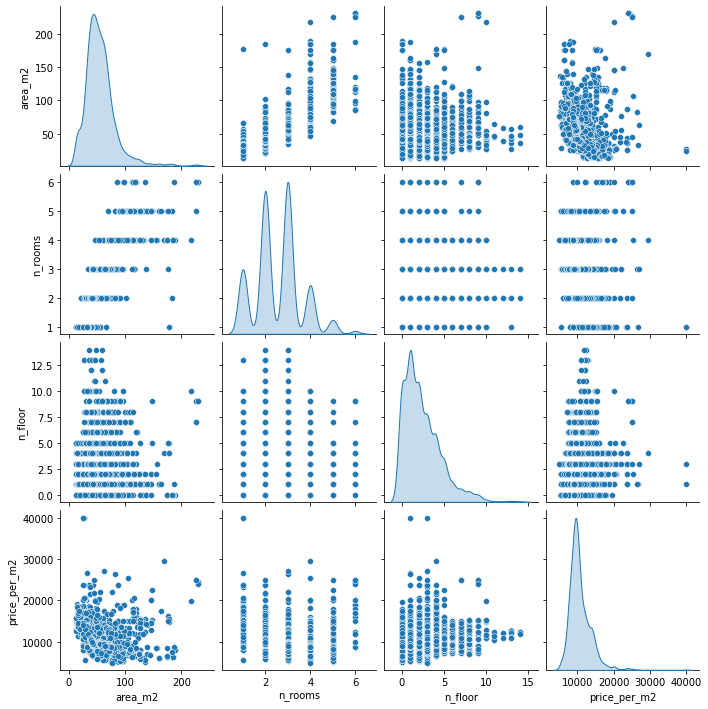

In [8]:
# wykres zależności między cechami
sns.pairplot(model_df, diag_kind="kde");

In [9]:
px.box(model_df, x = "area_m2", title = "Rozrzut cechy - powierzchnia", orientation = "h")

In [10]:
px.box(model_df, x = "n_rooms", title = "Rozrzut cechy - liczba pokoi", orientation = "h")

In [11]:
px.box(model_df, x = "n_floor", title = "Rozrzut cechy - nr piętra", orientation = "h")

In [12]:
px.box(model_df, x = "price_per_m2", title = "Rozrzut cechy - cena", orientation = "h")

In [13]:
px.scatter(model_df, x = "price_per_m2", title = "Rozrzut cechy - cena")

In [14]:
px.scatter(model_df, x = "area_m2", title = "Rozrzut cechy - powierzchnia")

In [15]:
px.scatter(model_df, x = "n_rooms", title = "Rozrzut cechy - liczba pokoi")

In [16]:
px.scatter(model_df, x = "n_floor", title = "Rozrzut cechy - nr piętra")

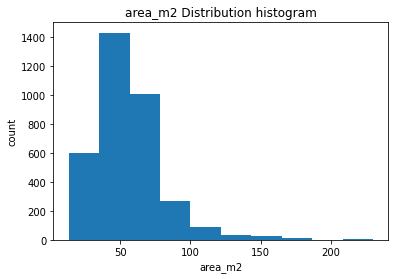

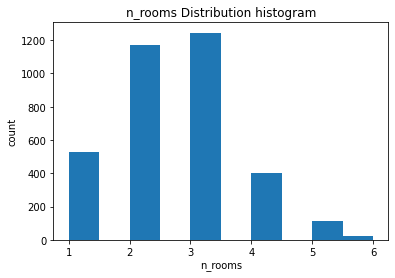

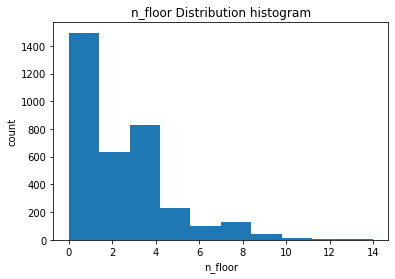

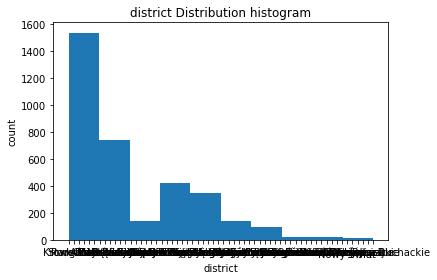

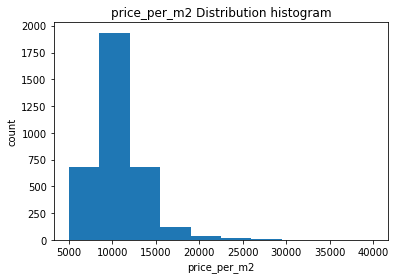

In [17]:
#data distribution - list of histograms

for column in model_df.columns:
  plt.hist(column, data = model_df)
  plt.title(label = column + ' Distribution histogram')
  plt.ylabel(ylabel = 'count')
  plt.xlabel(xlabel= column)
  plt.show()

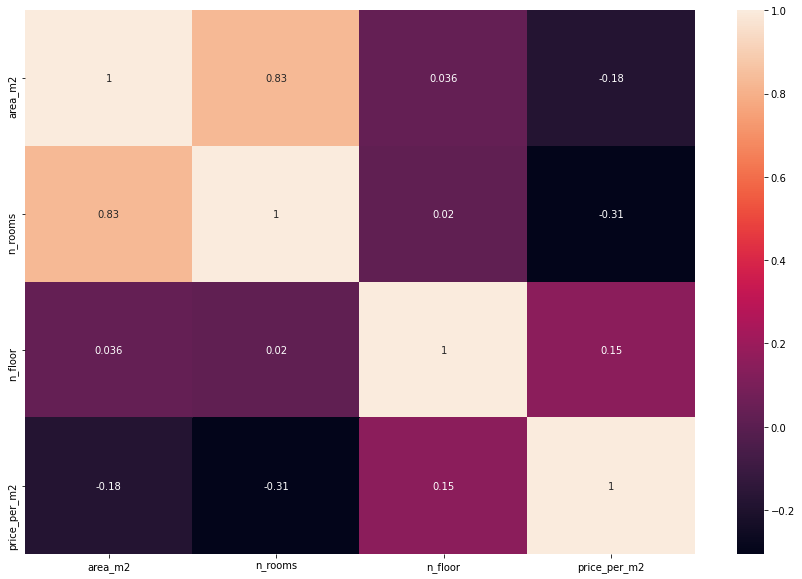

In [18]:
plt.figure(figsize=(15, 10))
corr = model_df.corr()
sns.heatmap(corr,annot=True);

##Wartości odstające

###Powierzchnia

In [19]:
# tworzenie funkcji do identyfikacji anomalii (Q1~10%, Q3~90%)
def IQR_outliers(a):
  Q1, Q3 = np.percentile(a, [10, 90])
  IQR = Q3 - Q1

  gorne_ograniczenie  = Q3 + (1.5 * IQR)
  dolne_ograniczenie  = Q1 - (1.5 * IQR)
  print("Górne ograniczenie:", gorne_ograniczenie)
  print("Dolne ograniczenie:", dolne_ograniczenie)

  indeksy = np.where((a > gorne_ograniczenie) | (a < dolne_ograniczenie))
  b = np.full(shape=a.shape[0], fill_value=1)
  b[indeksy] = -1
  
  return b

# użycie funkcji
model_df["flaga_IQR"] = IQR_outliers(model_df["area_m2"])
print(model_df["flaga_IQR"])

# wizualizacja wartości odstających wg. powierzchni
px.scatter(model_df, 
           x = "price_per_m2", 
           y = "area_m2",
           hover_name = "district",
           color = "flaga_IQR", 
           title = "Rozrzut cechy - powierzchnia (area_m2) a wartości odstające")

Górne ograniczenie: 164.20999999999998
Dolne ograniczenie: -51.629999999999995
0       1
1       1
2       1
3       1
4       1
       ..
3476    1
3477    1
3478    1
3479    1
3480    1
Name: flaga_IQR, Length: 3481, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [20]:
# usuwanie obserwacji odstajacych wg. powierzchni
model_df_2 = model_df[model_df["flaga_IQR"]==1]
model_df_2.shape

(3454, 6)

### Liczba pokoi

In [21]:
# tworzenie funkcji do identyfikacji anomalii (Q1~20%, Q3~80%)
def IQR_outliers(a):
  Q1, Q3 = np.percentile(a, [20, 80])
  IQR = Q3 - Q1

  gorne_ograniczenie  = Q3 + (2.0 * IQR)
  dolne_ograniczenie  = Q1 - (1.5 * IQR)
  print("Górne ograniczenie:", gorne_ograniczenie)
  print("Dolne ograniczenie:", dolne_ograniczenie)

  indeksy = np.where((a > gorne_ograniczenie) | (a < dolne_ograniczenie))
  b = np.full(shape=a.shape[0], fill_value=1)
  b[indeksy] = -1
  
  return b

# użycie funkcji
model_df_2["flaga_IQR"] = IQR_outliers(model_df_2["n_rooms"])
print(model_df_2["flaga_IQR"])

# wizualizacja wartości odstających wg. liczby pokoi
px.scatter(model_df_2, 
           x = "price_per_m2", 
           y = "n_rooms",
           hover_name = "district",
           color = "flaga_IQR", 
           title = "Rozrzut cechy - liczba pokoi (n_rooms) a wartości odstające")

Górne ograniczenie: 5.0
Dolne ograniczenie: 0.5
0       1
1       1
2       1
3       1
4       1
       ..
3476    1
3477    1
3478    1
3479    1
3480    1
Name: flaga_IQR, Length: 3454, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [22]:
# usuwanie obserwacji odstajacych wg. liczby pokoi
model_df_3 = model_df_2[model_df_2["flaga_IQR"]==1]
model_df_3.shape

(3439, 6)

###Numer piętra

In [23]:
# tworzenie funkcji do identyfikacji anomalii (Q1~25%, Q3~75%)
def IQR_outliers(a):
  Q1, Q3 = np.percentile(a, [25, 75])
  IQR = Q3 - Q1

  gorne_ograniczenie  = Q3 + (1.5 * IQR)
  dolne_ograniczenie  = Q1 - (1.5 * IQR)
  print("Górne ograniczenie:", gorne_ograniczenie)
  print("Dolne ograniczenie:", dolne_ograniczenie)

  indeksy = np.where((a > gorne_ograniczenie) | (a < dolne_ograniczenie))
  b = np.full(shape=a.shape[0], fill_value=1)
  b[indeksy] = -1
  
  return b

# użycie funkcji
model_df_3["flaga_IQR"] = IQR_outliers(model_df_3["n_floor"])
print(model_df_3["flaga_IQR"])

# wizualizacja wartości odstających wg. nr piętra
px.scatter(model_df_3, 
           x = "price_per_m2", 
           y = "n_floor",
           hover_name = "district",
           color = "flaga_IQR", 
           title = "Rozrzut cechy - numer piętra (n_floor) a wartości odstające")

Górne ograniczenie: 8.5
Dolne ograniczenie: -3.5
0       1
1       1
2       1
3       1
4       1
       ..
3476    1
3477    1
3478    1
3479    1
3480    1
Name: flaga_IQR, Length: 3439, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [24]:
# usuwanie obserwacji odstajacych wg. numeru piętra
model_df_4 = model_df_3[model_df_3["flaga_IQR"]==1]
model_df_4.shape

(3378, 6)

###Cena

In [25]:
# tworzenie funkcji do identyfikacji anomalii (Q1~15%, Q3~85%)
def IQR_outliers(a):
  Q1, Q3 = np.percentile(a, [15, 85])
  IQR = Q3 - Q1

  gorne_ograniczenie  = Q3 + (1.5 * IQR)
  dolne_ograniczenie  = Q1 - (1.5 * IQR)
  print("Górne ograniczenie:", gorne_ograniczenie)
  print("Dolne ograniczenie:", dolne_ograniczenie)

  indeksy = np.where((a > gorne_ograniczenie) | (a < dolne_ograniczenie))
  b = np.full(shape=a.shape[0], fill_value=1)
  b[indeksy] = -1
  
  return b

# użycie funkcji
model_df_4["flaga_IQR"] = IQR_outliers(model_df_4["price_per_m2"])
print(model_df_4["flaga_IQR"])

# wizualizacja wartości odstających wg. ceny 1 m2 mieszkania
px.scatter(model_df_4, 
           x = "price_per_m2", 
           #y = "n_floor",
           hover_name = "district",
           color = "flaga_IQR", 
           title = "Rozrzut cechy - cena (price_per_m2) a wartości odstające")

Górne ograniczenie: 21122.94999999999
Dolne ograniczenie: 371.3500000000049
0       1
1       1
2       1
3       1
4       1
       ..
3476    1
3477    1
3478    1
3479    1
3480    1
Name: flaga_IQR, Length: 3378, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [26]:
# usuwanie obserwacji odstajacych wg. numeru piętra
model_df_5 = model_df_4[model_df_4["flaga_IQR"]==1]
model_df_5.shape

(3355, 6)

In [27]:
# oblicznie % usuniętych obserwacji
print("% usuniętych obserwacji odstających: ", ((model_df.shape[0]-model_df_5.shape[0])/model_df.shape[0])*100)

% usuniętych obserwacji odstających:  3.619649525998277


In [28]:
# usuwanie nieużuwanej cechy - flaga_IQR
model_df_5.drop(columns = ["flaga_IQR"], inplace = True)
model_df_5

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,area_m2,n_rooms,n_floor,district,price_per_m2
0,44.93,2,7.0,Krowodrza,10700
1,42.00,2,1.0,Podgórze,7024
2,59.15,3,1.0,Krowodrza,9400
3,50.56,2,7.0,Krowodrza,10300
4,76.35,4,6.0,Krowodrza,9700
...,...,...,...,...,...
3476,42.22,2,0.0,Płaszów,9995
3477,67.07,3,1.0,Płaszów,8916
3478,63.05,3,1.0,Płaszów,9056
3479,62.59,3,0.0,Płaszów,9394


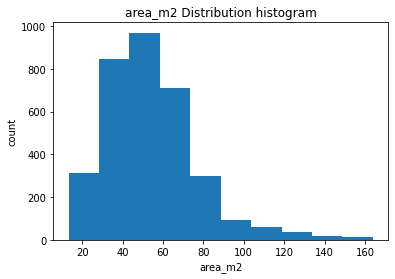

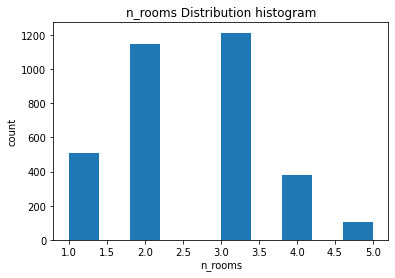

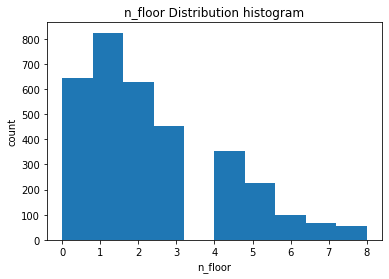

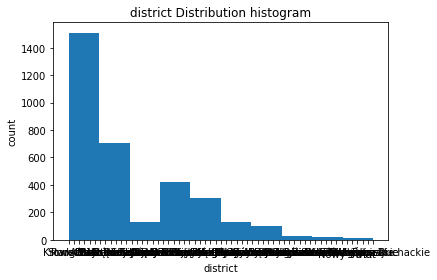

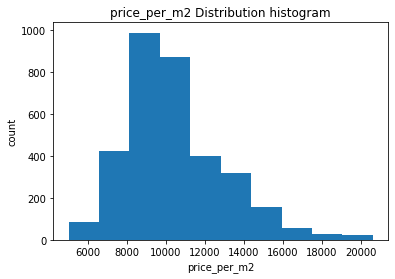

In [29]:
#data distribution - list of histograms

for column in model_df_5.columns:
  plt.hist(column, data = model_df_5)
  plt.title(label = column + ' Distribution histogram')
  plt.ylabel(ylabel = 'count')
  plt.xlabel(xlabel= column)
  plt.show()

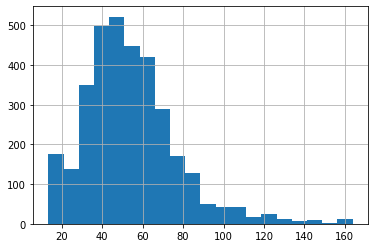

In [30]:
#powierzchnia- rozkład 
model_df_5.area_m2.hist(bins=20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



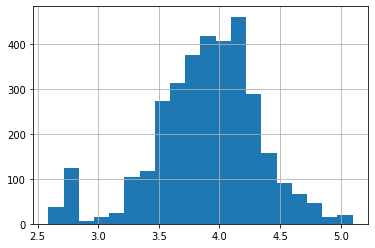

In [31]:
#powierzchnia- rozkład symetryczny
model_df_5['area_m2_log'] = np.log( model_df_5.area_m2 )
model_df_5['area_m2_log'].hist(bins=20)

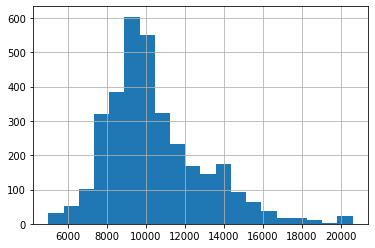

In [32]:
#cena- rozkład 
model_df_5.price_per_m2.hist(bins=20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



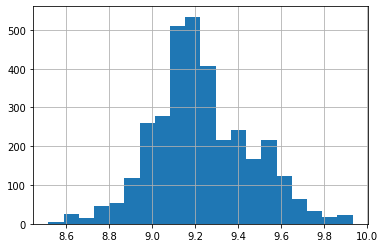

In [33]:
#cena- rozkład symetryczny
model_df_5['price_per_m2_log'] = np.log( model_df_5.price_per_m2 )
model_df_5['price_per_m2_log'].hist(bins=20)

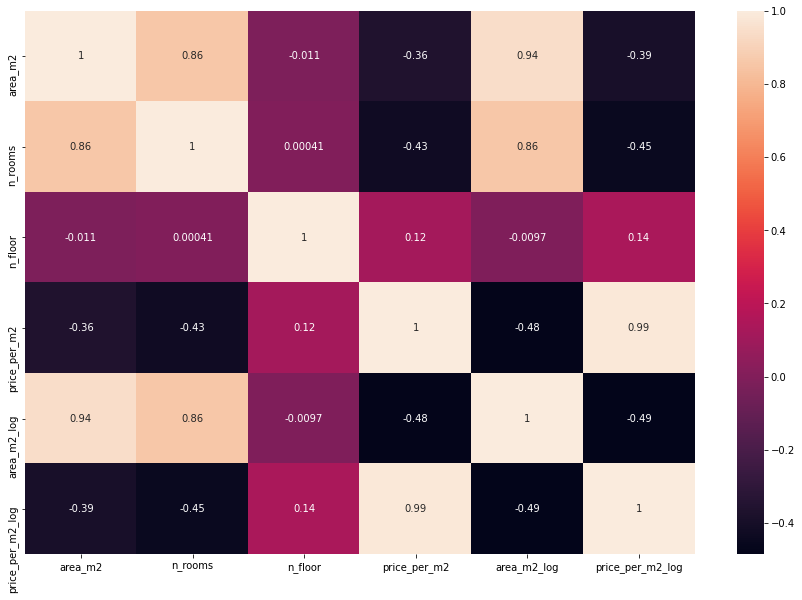

In [34]:
plt.figure(figsize=(15, 10))
corr=model_df_5.corr()
sns.heatmap(corr,annot=True);

##Zmienne kategoryczne

### Dzielnica

In [35]:
model_df_5["district"].value_counts()

brak                      554
Podgórze                  375
Mistrzejowice             280
Płaszów                   280
Prądnik Biały             275
Grzegórzki                227
Krowodrza                 209
Zabłocie                  156
Wola Duchacka             108
Os. Prądnik Biały          92
Bieżanów                   83
Dębniki                    73
Stare Miasto               66
Prądnik Czerwony           57
Górka Narodowa             42
Wola Justowska             40
Nowa Huta                  40
Bronowice Małe             31
Salwator                   29
Czyżyny Stare              29
Azory                      25
Czyżyny                    25
Os. Prądnik Czerwony       24
Os. Kliny Zacisze          20
Os. Ruczaj                 18
Bronowice                  18
Zwierzyniec                17
Olsza                      16
Podgórze Stare             14
Dąbie                      13
Sidzina                    11
Os. Złocień                11
Kazimierz                   8
Bronowice 

In [36]:
# kodowanie kategorii 
model_df_6 = pd.get_dummies(model_df_5, columns=["district"], prefix_sep="_")
model_df_6

,area_m2,n_rooms,n_floor,price_per_m2,area_m2_log,price_per_m2_log,district_Azory,district_Bielany,district_Bieżanów,district_Borek Fałęcki,district_Bronowice,district_Bronowice Małe,district_Bronowice Wielkie,district_Cichy Kącik,district_Czyżyny,district_Czyżyny Stare,district_Dąbie,district_Dębniki,district_Grzegórzki,district_Grzegórzki Stare,district_Górka Narodowa,district_Kazimierz,district_Kleparz,district_Krowodrza,district_Kurdwanów,district_Ludwinów,district_Mateczny,district_Mistrzejowice,district_Nowa Huta,district_Nowa Wieś,district_Nowy Świat,district_Olsza,district_Olszanica,district_Opatkowice,district_Os. Bieżanów Nowy,district_Os. Kliny Zacisze,district_Os. Mistrzejowice Nowe,district_Os. Prądnik Biały,district_Os. Prądnik Czerwony,district_Os. Ruczaj,district_Os. Złocień,district_Podgórze,district_Podgórze Stare,district_Prądnik Biały,district_Prądnik Czerwony,district_Pychowice,district_Półwsie Zwierzynieckie,district_Płaszów,district_Ruczaj,district_Salwator,district_Sidzina,district_Stare Miasto,district_Swoszowice,district_Tonie,district_Ugorek,district_Warszawskie,district_Witkowice,district_Wola Duchacka,district_Wola Justowska,district_XI Podgórze Duchackie,district_Zabłocie,district_Zwierzyniec,district_brak,district_Łagiewniki,district_Łobzów
0,44.93,2,7.0,10700,3.805106,9.277999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,42.00,2,1.0,7024,3.737670,8.857088,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,59.15,3,1.0,9400,4.080077,9.148465,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,50.56,2,7.0,10300,3.923161,9.239899,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,76.35,4,6.0,9700,4.335328,9.179881,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3476,42.22,2,0.0,9995,3.742894,9.209840,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3477,67.07,3,1.0,8916,4.205737,9.095603,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3478,63.05,3,1.0,9056,4.143928,9.111183,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3479,62.59,3,0.0,9394,4.136606,9.147826,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Sprawdzanie korelacji


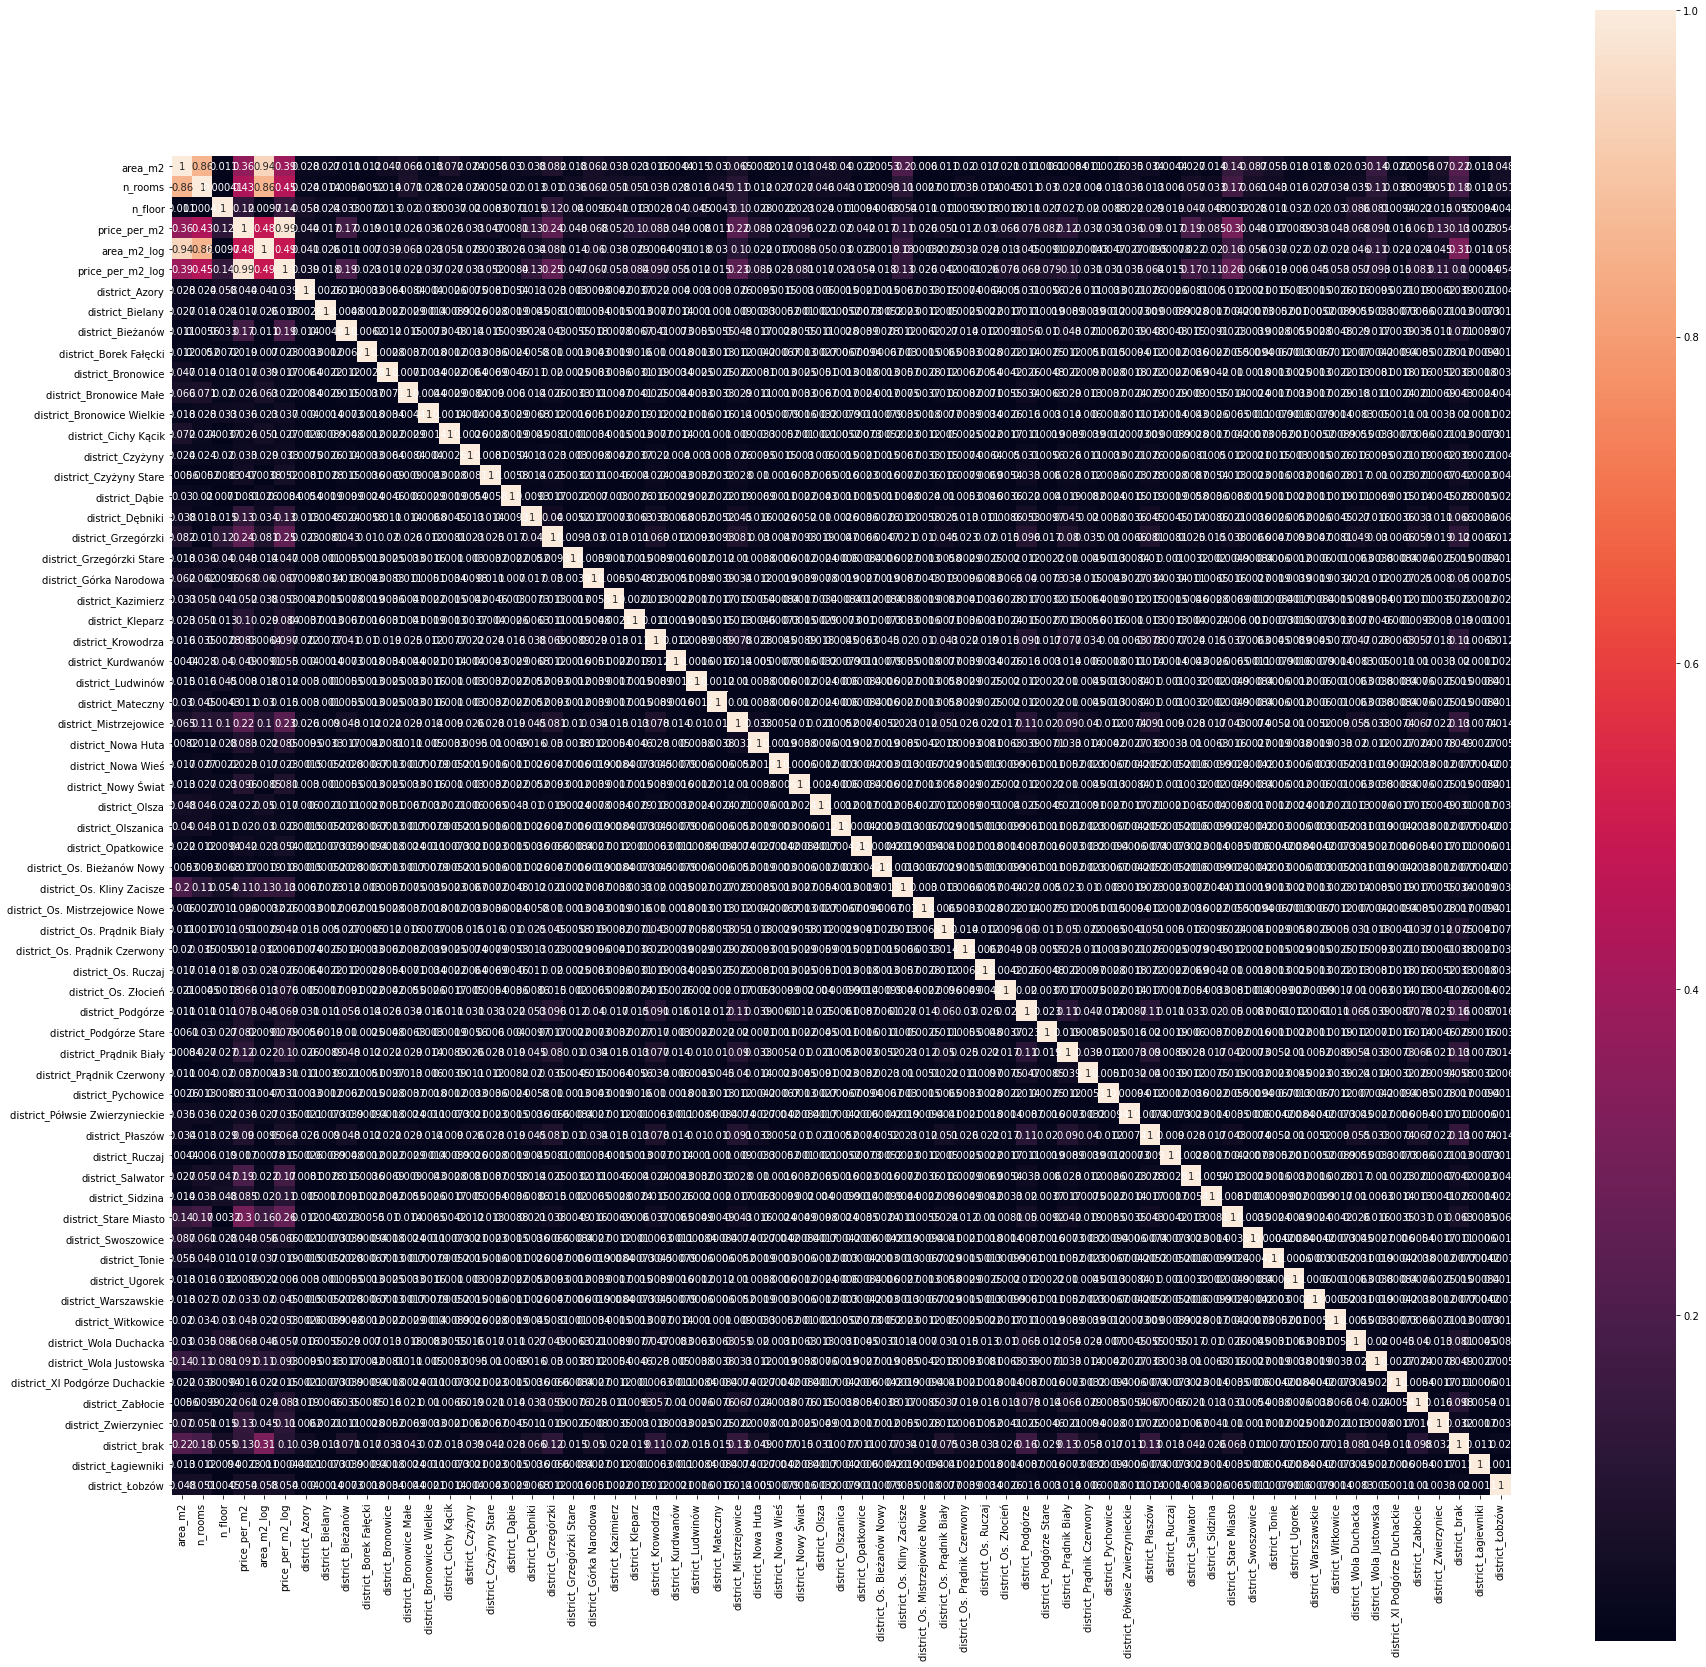

In [37]:
plt.figure(figsize = (30, 30))
corr = model_df_6.corr().abs()
sns.heatmap(corr, square = True, annot = True);

In [38]:
# zdefiniowanie macierzy do filtrowania
macierz_filter = np.triu(np.ones(corr.shape), k=1).astype(np.bool)

# wybranie górnej części trójkąta w macierzy korelacji
gorny_trojkat = corr.where(macierz_filter)

# zdefiniowanie indeksów kolumn o korelacji powyżej 0.9
indeks_mocna_korelacja = [kolumna for kolumna in gorny_trojkat.columns if any(gorny_trojkat[kolumna] > 0.9)]
print(indeks_mocna_korelacja)
# brak mocnej  korelacji w danych

['area_m2_log', 'price_per_m2_log']


In [39]:
# zdefiniowanie indeksów kolumn o korelacji poniżej 0.1
indeks_slaba_korelacja = [kolumna for kolumna in gorny_trojkat.columns if any(gorny_trojkat[kolumna] < 0.1)]
print(indeks_slaba_korelacja)

['n_floor', 'area_m2_log', 'district_Azory', 'district_Bielany', 'district_Bieżanów', 'district_Borek Fałęcki', 'district_Bronowice', 'district_Bronowice Małe', 'district_Bronowice Wielkie', 'district_Cichy Kącik', 'district_Czyżyny', 'district_Czyżyny Stare', 'district_Dąbie', 'district_Dębniki', 'district_Grzegórzki', 'district_Grzegórzki Stare', 'district_Górka Narodowa', 'district_Kazimierz', 'district_Kleparz', 'district_Krowodrza', 'district_Kurdwanów', 'district_Ludwinów', 'district_Mateczny', 'district_Mistrzejowice', 'district_Nowa Huta', 'district_Nowa Wieś', 'district_Nowy Świat', 'district_Olsza', 'district_Olszanica', 'district_Opatkowice', 'district_Os. Bieżanów Nowy', 'district_Os. Kliny Zacisze', 'district_Os. Mistrzejowice Nowe', 'district_Os. Prądnik Biały', 'district_Os. Prądnik Czerwony', 'district_Os. Ruczaj', 'district_Os. Złocień', 'district_Podgórze', 'district_Podgórze Stare', 'district_Prądnik Biały', 'district_Prądnik Czerwony', 'district_Pychowice', 'distric

In [ ]:
# usunięcie slabo skorelowanych cech
#model_df_6.drop(columns=indeks_slaba_korelacja, inplace=True, errors= 'ignore')

#model_df_6.head()

##Podział zbioru na uczący i testowy

In [ ]:
#model_df_6 = model_df_6.reset_index()

In [40]:
# tworzenie zbiorów test i train
X_train, X_test, y_train, y_test = model_selection.train_test_split(model_df_6.drop(columns=["price_per_m2","price_per_m2_log"]), 
                                                                    model_df_6["price_per_m2"], 
                                                                    test_size=.2, 
                                                                    random_state=2021)

In [41]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2684 entries, 1049 to 1189
Data columns (total 63 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   area_m2                          2684 non-null   float64
 1   n_rooms                          2684 non-null   int64  
 2   n_floor                          2684 non-null   float64
 3   area_m2_log                      2684 non-null   float64
 4   district_Azory                   2684 non-null   uint8  
 5   district_Bielany                 2684 non-null   uint8  
 6   district_Bieżanów                2684 non-null   uint8  
 7   district_Borek Fałęcki           2684 non-null   uint8  
 8   district_Bronowice               2684 non-null   uint8  
 9   district_Bronowice Małe          2684 non-null   uint8  
 10  district_Bronowice Wielkie       2684 non-null   uint8  
 11  district_Cichy Kącik             2684 non-null   uint8  
 12  district_Czyżyny 

In [42]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 671 entries, 1153 to 1252
Data columns (total 63 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   area_m2                          671 non-null    float64
 1   n_rooms                          671 non-null    int64  
 2   n_floor                          671 non-null    float64
 3   area_m2_log                      671 non-null    float64
 4   district_Azory                   671 non-null    uint8  
 5   district_Bielany                 671 non-null    uint8  
 6   district_Bieżanów                671 non-null    uint8  
 7   district_Borek Fałęcki           671 non-null    uint8  
 8   district_Bronowice               671 non-null    uint8  
 9   district_Bronowice Małe          671 non-null    uint8  
 10  district_Bronowice Wielkie       671 non-null    uint8  
 11  district_Cichy Kącik             671 non-null    uint8  
 12  district_Czyżyny  

In [43]:
y_train

1049     9150
3005    14000
195      9792
589     10400
830     11900
        ...  
2089     9159
2774    13000
1201     9000
2189     8835
1189    11367
Name: price_per_m2, Length: 2684, dtype: int64

In [44]:
y_test

1153     7949
2944     8430
2874    17306
2015    10377
1315    11900
        ...  
1641     9618
322      5993
2708     8300
3288     9600
1252    10997
Name: price_per_m2, Length: 671, dtype: int64

## Standaryzacja zmiennych

In [45]:
print("Dane przed standaryzacją X_train:\n", X_train)
print("Dane przed standaryzacją X_test:\n", X_test)

Dane przed standaryzacją X_train:
       area_m2  n_rooms  ...  district_Łagiewniki  district_Łobzów
1049    26.43        1  ...                    0                0
3005    35.73        1  ...                    0                0
195     46.10        2  ...                    0                0
589     45.76        2  ...                    0                0
830     27.30        1  ...                    0                0
...       ...      ...  ...                  ...              ...
2089    65.00        3  ...                    0                0
2774    29.14        2  ...                    0                0
1201    48.31        2  ...                    0                0
2189    43.98        2  ...                    0                0
1189    43.90        2  ...                    0                0

[2684 rows x 63 columns]
Dane przed standaryzacją X_test:
       area_m2  n_rooms  ...  district_Łagiewniki  district_Łobzów
1153    71.53        4  ...                    

In [46]:
# zdefiniowanie standaryzatora
stand = preprocessing.StandardScaler()

# standaryzacja danych
stand_data_Xtrain = stand.fit_transform(X_train)
stand_data_Xtest = stand.fit_transform(X_test)

print("Dane zestandaryzowane X_train:\n", stand_data_Xtrain)
print("\n")
print("Średnia:", stand_data_Xtrain.mean(axis=0).round())
print("Odch. standardowe:", stand_data_Xtrain.std(axis=0))
print(("\n") * 3)
print("Dane zestandaryzowane X_test:\n", stand_data_Xtest)
print("\n")
print("Średnia:", stand_data_Xtest.mean(axis=0).round())
print("Odch. standardowe:", stand_data_Xtest.std(axis=0))

Dane zestandaryzowane X_train:
 [[-1.20530917 -1.55453009  0.90651683 ... -0.43919118 -0.02730773
  -0.03863337]
 [-0.80039612 -1.55453009  0.39004662 ... -0.43919118 -0.02730773
  -0.03863337]
 [-0.34889629 -0.53935764  2.45592748 ... -0.43919118 -0.02730773
  -0.03863337]
 ...
 [-0.25267501 -0.53935764 -1.15936402 ... -0.43919118 -0.02730773
  -0.03863337]
 [-0.44119905 -0.53935764  0.90651683 ... -0.43919118 -0.02730773
  -0.03863337]
 [-0.44468217 -0.53935764  1.42298705 ... -0.43919118 -0.02730773
  -0.03863337]]


Średnia: [ 0. -0.  0.  0.  0. -0. -0. -0.  0. -0. -0.  0.  0.  0. -0. -0.  0. -0.
  0.  0. -0. -0.  0.  0.  0.  0.  0. -0.  0.  0.  0. -0. -0. -0. -0. -0.
 -0. -0. -0.  0. -0.  0. -0. -0. -0.  0.  0. -0. -0.  0.  0.  0. -0. -0.
  0.  0.  0.  0.  0. -0.  0. -0. -0.]
Odch. standardowe: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

## Wyuczenie modelu

### Model regresji liniowej

In [49]:
from sklearn import linear_model
from sklearn import metrics

# przygotowanie modelu LinearRegression
model_rl = linear_model.LinearRegression()
model_rl.fit(stand_data_Xtrain, y_train)

# obliczenie Mean Squared Error (MSE) - błąd średniokwadratowy na całym zbiorze testowym
predykcja_model_rl = model_rl.predict(stand_data_Xtest)
rl_mse = metrics.mean_squared_error(y_test, predykcja_model_rl)
print("MSE - LinearRegression: ", rl_mse)

# obliczenie odchylenia średniej kwadradowej od wartości rzeczywistej 
# Root Mean Square Error (RMSE) - pierwiastek błędu średniokwadratowego
rl_rmse = np.sqrt(rl_mse)
print("RMSE - LinearRegression: ", rl_rmse)

MSE - LinearRegression:  1.404053765527965e+28
RMSE - LinearRegression:  118492774696517.47


###Model drzew decyzyjnych

In [50]:
from sklearn import tree

# przygotowanie modelu DecisionTreeRegressor()
model_dtr = tree.DecisionTreeRegressor()
model_dtr.fit(stand_data_Xtrain, y_train)

# obliczenie Mean Squared Error (MSE) - błąd średniokwadratowy na całym zbiorze testowym
predykcja_model_dtr = model_dtr.predict(stand_data_Xtest)
dtr_mse = metrics.mean_squared_error(y_test, predykcja_model_dtr)
print("MSE - DecisionTreeRegressor: ", dtr_mse)

# obliczenie odchylenia średniej kwadradowej od wartości rzeczywistej 
# Root Mean Square Error (RMSE) - pierwiastek błędu średniokwadratowego
dtr_rmse = np.sqrt(dtr_mse)
print("RMSE - DecisionTreeRegressor: ", dtr_rmse) 

MSE - DecisionTreeRegressor:  3567411.304996688
RMSE - DecisionTreeRegressor:  1888.7591971971144


###Wstępna walidacja modelu drzew decyzyjnych

In [51]:
from sklearn import pipeline

## tworzenie procesu standaryzacji i doboru modelu przy każdym podziale walidacji krzyżowej
# utworzenie metody standaryzacji danych
standaryzacja = preprocessing.StandardScaler()

# wybranie metody modelowania
algo = tree.DecisionTreeRegressor(random_state=2021)

# utworzenie procesu standaryzacji i wykorzystania algorytmu drzew decyzyjnych
proces = pipeline.make_pipeline(standaryzacja, algo)

# zdefiniowanie metody walidacji modelu
walidacja = model_selection.KFold(n_splits=10, shuffle=True, random_state=2021)

# krzyżowa walidacja modelu DecisionTreeRegressor ze sprawdzeniem niegatywnego błędu średniokwadratowego - MSE
walidacja_neg_MSE_dtr = model_selection.cross_val_score(proces, 
                                                        X_train,
                                                        y_train,
                                                        cv = walidacja,
                                                        scoring = "neg_mean_squared_error",
                                                        n_jobs = -1)

# obliczenie odchylenia średniej kwadradowej od wartości rzeczywistej 
# Root Mean Square Error (RMSE) - pierwiastek błędu średniokwadratowego
# "-" bo MSE wyliczona jako wartość niegatywna
walidacja_RMSE_dtr = np.sqrt(-walidacja_neg_MSE_dtr)

# podsumowanie dla DecisionTreeRegressor
print("Średnia wartość RMSE - DecisionTreeRegressor: ", walidacja_RMSE_dtr.mean())
print("Mediana wartość RMSE - DecisionTreeRegressor: ", np.median(walidacja_RMSE_dtr))
print("Odchylenie standardowe RMSE - DecisionTreeRegressor: ", walidacja_RMSE_dtr.std())

Średnia wartość RMSE - DecisionTreeRegressor:  1630.3187689230629
Mediana wartość RMSE - DecisionTreeRegressor:  1652.7541232079764
Odchylenie standardowe RMSE - DecisionTreeRegressor:  179.59277790166826


###Model lasów losowych

In [52]:
from sklearn import ensemble

## tworzenie procesu standaryzacji i doboru modelu przy każdym podziale walidacji krzyżowej
# utworzenie metody standaryzacji danych
standaryzacja = preprocessing.StandardScaler()

# wybranie metody modelowania
algo = ensemble.RandomForestRegressor(random_state=2021)

# utworzenie procesu standaryzacji i wykorzystania algorytmu lasów losowych
proces = pipeline.make_pipeline(standaryzacja, algo)

# zdefiniowanie metody walidacji modelu
walidacja = model_selection.KFold(n_splits=10, shuffle=True, random_state=2021)

# krzyżowa walidacja modelu RandomForestRegressor ze sprawdzeniem niegatywnego błędu średniokwadratowego - MSE
walidacja_neg_MSE_rfr = model_selection.cross_val_score(proces, 
                                                        X_train,
                                                        y_train,
                                                        cv = walidacja,
                                                        scoring = "neg_mean_squared_error",
                                                        n_jobs = -1)

# obliczenie odchylenia średniej kwadradowej od wartości rzeczywistej 
# Root Mean Square Error (RMSE) - pierwiastek błędu średniokwadratowego
# "-" bo MSE wyliczona jako wartość niegatywna
walidacja_RMSE_rfr = np.sqrt(-walidacja_neg_MSE_rfr)

# podsumowanie dla RandomForestRegressor
print("Średnia wartość RMSE - RandomForestRegressor: ", walidacja_RMSE_rfr.mean())
print("Mediana wartość RMSE - RandomForestRegressor: ", np.median(walidacja_RMSE_rfr))
print("Odchylenie standardowe RMSE - RandomForestRegressor: ", walidacja_RMSE_rfr.std())

Średnia wartość RMSE - RandomForestRegressor:  1322.7837708658953
Mediana wartość RMSE - RandomForestRegressor:  1303.6404987737392
Odchylenie standardowe RMSE - RandomForestRegressor:  137.22543004899936


### Model ElasticNet

In [53]:
# przygotowanie modelu ElasticNet
model_en = linear_model.ElasticNet()
model_en.fit(stand_data_Xtrain, y_train)

# obliczenie Mean Squared Error (MSE) - błąd średniokwadratowy na całym zbiorze testowym
predykcja_model_en = model_en.predict(stand_data_Xtest)
en_mse = metrics.mean_squared_error(y_test, predykcja_model_en)
print("MSE - ElasticNet: ", en_mse)

# obliczenie odchylenia średniej kwadradowej od wartości rzeczywistej 
# Root Mean Square Error (RMSE) - pierwiastek błędu średniokwadratowego
en_rmse = np.sqrt(en_mse)
print("RMSE - ElasticNet: ", en_rmse)

MSE - ElasticNet:  3168274.061713389
RMSE - ElasticNet:  1779.9646237252553


### Model Lasso

In [54]:
# przygotowanie modelu Lasso
model_l = linear_model.Lasso()
model_l.fit(stand_data_Xtrain, y_train)

# obliczenie Mean Squared Error (MSE) - błąd średniokwadratowy na całym zbiorze testowym
predykcja_model_l = model_l.predict(stand_data_Xtest)
l_mse = metrics.mean_squared_error(y_test, predykcja_model_l)
print("MSE - Lasso: ", l_mse)

# obliczenie odchylenia średniej kwadradowej od wartości rzeczywistej 
# Root Mean Square Error (RMSE) - pierwiastek błędu średniokwadratowego
l_rmse = np.sqrt(l_mse)
print("RMSE - Lasso: ", l_rmse)

MSE - Lasso:  2519454.8772229804
RMSE - Lasso:  1587.2790798164576


### Model XGBRegressor

In [55]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error

xgb = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=50, random_state=2021, max_depth=9, learning_rate=0.2, subsample=1,colsample_bytree = 1)
#xgb = XGBRegressor(min_child_wieght= 1,subsample=1,colsample_bytree = 1,max_depth = 9)

xgb.fit(stand_data_Xtrain,y_train)
y_pred = xgb.predict(stand_data_Xtest)
mse = mean_squared_error(y_pred,y_test)

# podsumowanie dla XGBRegressor
print("RMSE - XGBRegressor: ", np.sqrt(mse))


RMSE - XGBRegressor:  1485.1562069431775


### Optymalizacja modelu lasów losowych

#### Całkowite wyszukiwanie parametrów modelu- GridSearchCV()

In [56]:
from sklearn import pipeline
import time

licznik_start = time.time()

## metoda przeszukania całej siatki parametrów - GridSearchCV()

# wybranie metody modelowania - RandomForestRegressor()
algo = ensemble.RandomForestRegressor(random_state=2021)

# tworzenie siatki parametrów
# 24+36 kombinacji wartości hiperparametrów modelu
siatka_parametrow = [{
                      # liczba dzrzew
                      "n_estimators": [20, 50, 100],
                      # minimalna liczba próbek wymagana do podzielenia węzła
                      "min_samples_split": [2, 5, 20, 50],
                      # maksymalna głębokość drzewa
                      "max_depth": [3, 10, None]
                      },
                     
                     {
                      # metoda doboru próbek do uczenia każdego drzewa
                      "bootstrap": [False, True], #False->cały zestaw danych jest używany do budowania każdego drzewa
                      # liczba dzrzew
                      "n_estimators": [10, 100, 300, 500, 1000],
                      # minimalna liczba próbek wymaganych w każdym węźle liścia
                      "min_samples_leaf": [1, 3, 5],
                      # liczba cech/funkcji, które należy wziąć pod uwagę, szukając najlepszego podziału
                      "max_features": ["auto", "sqrt"] #auto->n_features, sqrt->sqrt(n_features)
                      }]

# zdefiniowanie metody walidacji modelu
walidacja = model_selection.KFold(n_splits=10, shuffle=True, random_state=2021)

# konfiguracja procesu przetestowania siatki parametrów
konfiguracja_procesu = pipeline.make_pipeline(preprocessing.StandardScaler(), 
                                              model_selection.GridSearchCV(algo, 
                                                                           siatka_parametrow,
                                                                           cv = walidacja,
                                                                           verbose = 5, #częstość wyświetlenia informacji przy modelowaniu
                                                                           scoring = "neg_mean_squared_error",
                                                                           n_jobs = -1))
# nauczanie modelu
konfiguracja_procesu.fit(X_train, y_train)

print("Czas pracy [min]: ", (time.time() - licznik_start)/60)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 230 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done 356 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 716 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done 950 tasks      | elapsed: 29.5min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed: 29.9min finished


Czas pracy [min]:  29.986669890085857


In [57]:
# pobranie wyników procesu - gridsearchcv
konfiguracja_siatki_parametrow = konfiguracja_procesu.named_steps["gridsearchcv"]
konfiguracja_siatki_parametrow

GridSearchCV(cv=KFold(n_splits=10, random_state=2021, shuffle=True),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n...
             iid='deprecated', n_jobs=-1,
             param_grid=[{'max_depth': [3, 10, None],
                          'min_samples_split': [2, 5, 20, 

In [58]:
# względna istotność cech wykorzystanych do modelowania
istotnosc_cech_modelu = pd.DataFrame(dict(istotnosc=konfiguracja_siatki_parametrow.best_estimator_.feature_importances_, 
                                          cecha=X_train.columns.values)).sort_values(by="istotnosc", ascending=False)

# wizualizacja istotności cech
px.pie(istotnosc_cech_modelu, 
       values= "istotnosc", 
       names = "cecha", 
       title = "Względna istotność cech wykorzystywanych w modelu RandomForestRegressor")

In [59]:
# najlepsze parametry modelu
konfiguracja_siatki_parametrow.best_params_

{'bootstrap': True,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'n_estimators': 1000}

In [60]:
# wyświetlenie najlepszego estymatora
konfiguracja_siatki_parametrow.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=2021, verbose=0, warm_start=False)

In [61]:
## wykorzystanie najlepszegi modelu wytrzenowanego na zbiorze uczacym do testowania zbioru testowego
najlepszy_model_rfr = konfiguracja_siatki_parametrow.best_estimator_

# predykcja na podstawie najlepszego modelu
predykcja_najlepszy_model_rfr = najlepszy_model_rfr.predict(stand_data_Xtest)

# wyliczenie metryk
najlepszy_model_rfr_mse = metrics.mean_squared_error(y_test, predykcja_najlepszy_model_rfr)
print("MSE dla najlepszego modelu - RandomForestRegressor: ", najlepszy_model_rfr_mse)

najlepszy_model_rfr_rmse = np.sqrt(najlepszy_model_rfr_mse)
print("RMSE dla najlepszego modelu - RandomForestRegressor: ", najlepszy_model_rfr_rmse)

MSE dla najlepszego modelu - RandomForestRegressor:  2228889.472375581
RMSE dla najlepszego modelu - RandomForestRegressor:  1492.9465738517172


In [62]:
# pobranie wynikow testu - wskaźnik MSE
MSE_results = konfiguracja_siatki_parametrow.cv_results_['mean_test_score']
# wyliczenie wskaźnika RMSE
RMSE_results = np.sqrt(-MSE_results)

# pobranie hyperparametrów modelu
parametry = konfiguracja_siatki_parametrow.cv_results_['params']

# podsumowanie RMSE i hyperparametrów dla RandomForestRegressor
for RMSE, parametry in zip(RMSE_results, parametry):
  print(RMSE, parametry)

1902.282031136419 {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 20}
1897.6500211672592 {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 50}
1897.3602678535767 {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}
1902.282031136419 {'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 20}
1897.65068022122 {'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 50}
1897.3605693774878 {'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100}
1902.081730299971 {'max_depth': 3, 'min_samples_split': 20, 'n_estimators': 20}
1897.5456424870797 {'max_depth': 3, 'min_samples_split': 20, 'n_estimators': 50}
1897.3729454390113 {'max_depth': 3, 'min_samples_split': 20, 'n_estimators': 100}
1902.170436514405 {'max_depth': 3, 'min_samples_split': 50, 'n_estimators': 20}
1897.5186958382578 {'max_depth': 3, 'min_samples_split': 50, 'n_estimators': 50}
1897.3455375770122 {'max_depth': 3, 'min_samples_split': 50, 'n_estimators': 100}
1513.8297345133851 {'max_depth': 10,

In [63]:
from sklearn.externals import joblib

# zapisanie wytrenowanego modelu
joblib.dump(najlepszy_model_rfr, "model_random_forest_regressor_GSCV_v1.pkl")

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



['model_random_forest_regressor_GSCV_v1.pkl']

#### Losowe wyszukiwanie parametrów modelu - RandomizedSearchCV()

In [82]:
licznik_start = time.time()

## metoda przeszukania wylosowanych parametrów zprzygotowanej siatki parametrów - RandomizedSearchCV()

# wybranie metody modelowania - RandomForestRegressor()
algo = ensemble.RandomForestRegressor(random_state=2021)

# tworzenie siatki parametrów
max_depth = [int(i) for i in np.linspace(start = 3, stop = 100, num = 10)]
max_depth.append(None)

siatka_parametrow_random = {"n_estimators": [int(i) for i in np.linspace(start = 10, stop = 10000, num = 100)],
                            "max_features": ["auto", "sqrt"],
                            "bootstrap": [True, False],
                            "max_depth": max_depth,
                            "min_samples_leaf": [int(i) for i in np.linspace(start = 1, stop = 50, num = 100)],
                            "min_samples_split": [int(i) for i in np.linspace(start = 1, stop = 50, num = 100)]}

# zdefiniowanie metody walidacji modelu
walidacja = model_selection.KFold(n_splits=10, shuffle=True, random_state=2021)

# konfiguracja przetestowania siatki parametrów poprzez wylosowanie X zestawów parametrów
konfiguracja_procesu_random = pipeline.make_pipeline(preprocessing.StandardScaler(), 
                                                     model_selection.RandomizedSearchCV(algo, 
                                                                                        siatka_parametrow_random,
                                                                                        n_iter = 10,
                                                                                        verbose = 5, #częstość wyświetlenia informacji przy modelowaniu
                                                                                        cv = walidacja,
                                                                                        scoring = "neg_mean_squared_error",
                                                                                        n_jobs = -1))

# nauczanie modelu
konfiguracja_procesu_random.fit(X_train, y_train)

print("Czas pracy [min]: ", (time.time() - licznik_start)/60)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 22.6min finished


Czas pracy [min]:  24.223483701546986


In [83]:
# pobranie wyników procesu - randomizedsearchcv
konfiguracja_siatki_parametrow_random = konfiguracja_procesu_random.named_steps["randomizedsearchcv"]

In [84]:
# najlepsze parametry
konfiguracja_siatki_parametrow_random.best_params_

{'bootstrap': True,
 'max_depth': 56,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 31,
 'n_estimators': 9192}

In [85]:
# najlepszy estymator
model_rfr_random = konfiguracja_siatki_parametrow_random.best_estimator_
model_rfr_random

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=56, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=31, min_weight_fraction_leaf=0.0,
                      n_estimators=9192, n_jobs=None, oob_score=False,
                      random_state=2021, verbose=0, warm_start=False)

In [86]:
# predykcja na podstawie najlepszego modelu
predykcja_najlepszy_model_rfr_random = model_rfr_random.predict(stand_data_Xtest)

# wyliczenie metryk
najlepszy_model_rfr_mse_random = metrics.mean_squared_error(y_test, predykcja_najlepszy_model_rfr_random)
print("MSE dla najlepszego modelu - RandomForestRegressor: ", najlepszy_model_rfr_mse_random)

najlepszy_model_rfr_rmse_random = np.sqrt(najlepszy_model_rfr_mse_random)
print("RMSE dla najlepszego modelu - RandomForestRegressor: ", najlepszy_model_rfr_rmse_random)

MSE dla najlepszego modelu - RandomForestRegressor:  2318608.7645460484
RMSE dla najlepszego modelu - RandomForestRegressor:  1522.697857273743


In [87]:
# pobranie wynikow testu - wskaźnik MSE
MSE_results = konfiguracja_siatki_parametrow_random.cv_results_['mean_test_score']
# wyliczenie wskaźnika RMSE
RMSE_results = np.sqrt(-MSE_results)

# pobranie hyperparametrów modelu
parametry = konfiguracja_siatki_parametrow_random.cv_results_['params']

# podsumowanie RMSE i hyperparametrów dla RandomForestRegressor
for RMSE, parametry in zip(RMSE_results, parametry):
  print(RMSE, parametry)

1884.918805311909 {'n_estimators': 1927, 'min_samples_split': 2, 'min_samples_leaf': 36, 'max_features': 'auto', 'max_depth': 13, 'bootstrap': True}
2038.1087345826693 {'n_estimators': 3440, 'min_samples_split': 32, 'min_samples_leaf': 32, 'max_features': 'sqrt', 'max_depth': 78, 'bootstrap': True}
2056.1688018480336 {'n_estimators': 4550, 'min_samples_split': 22, 'min_samples_leaf': 35, 'max_features': 'sqrt', 'max_depth': 24, 'bootstrap': True}
1766.345954949103 {'n_estimators': 615, 'min_samples_split': 25, 'min_samples_leaf': 19, 'max_features': 'auto', 'max_depth': 13, 'bootstrap': False}
1895.3456831329684 {'n_estimators': 817, 'min_samples_split': 32, 'min_samples_leaf': 42, 'max_features': 'auto', 'max_depth': 78, 'bootstrap': True}
1899.364518639419 {'n_estimators': 5761, 'min_samples_split': 2, 'min_samples_leaf': 16, 'max_features': 'sqrt', 'max_depth': 56, 'bootstrap': True}
2149.15323618203 {'n_estimators': 9091, 'min_samples_split': 37, 'min_samples_leaf': 44, 'max_featur

In [88]:
# zapisanie wytrenowanego modelu
joblib.dump(model_rfr_random, "model_random_forest_regressor_RSCV_v1.pkl")

['model_random_forest_regressor_RSCV_v1.pkl']

### Optymalizacja modelu XGBRegressor

#### Całkowite wyszukiwanie parametrów modelu- GridSearchCV()

In [72]:
from sklearn import pipeline
import time

licznik_start = time.time()

## metoda przeszukania całej siatki parametrów - GridSearchCV()

# wybranie metody modelowania - XGBRegressor()
algo = ensemble.GradientBoostingRegressor(random_state=2021)

# tworzenie siatki parametrów

siatka_parametrow = {
                      # 
                      "n_estimators": [20, 50, 100],
                      # 
                      "learning_rate": [0.05, 0.1, 0.25, 0.5],
                      # 
                      "max_depth": [3, 10, None],
                      # 
                      "subsample": [0.75, 1]
                      }

# zdefiniowanie metody walidacji modelu
walidacja = model_selection.KFold(n_splits=10, shuffle=True, random_state=2021)

# konfiguracja procesu przetestowania siatki parametrów
konfiguracja_procesu = pipeline.make_pipeline(preprocessing.StandardScaler(), 
                                              model_selection.GridSearchCV(algo, 
                                                                           siatka_parametrow,
                                                                           cv = walidacja,
                                                                           verbose = 5, #częstość wyświetlenia informacji przy modelowaniu
                                                                           scoring = "neg_mean_squared_error",
                                                                           n_jobs = -1))
# nauczanie modelu
konfiguracja_procesu.fit(X_train, y_train)

print("Czas pracy [min]: ", (time.time() - licznik_start)/60)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   56.2s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  5.9min finished


Czas pracy [min]:  5.955749062697093


In [73]:
# pobranie wyników procesu - gridsearchcv
konfiguracja_siatki_parametrow = konfiguracja_procesu.named_steps["gridsearchcv"]
konfiguracja_siatki_parametrow

GridSearchCV(cv=KFold(n_splits=10, random_state=2021, shuffle=True),
             error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_we...
                                                 presort='deprecated',
                                          

In [74]:
# względna istotność cech wykorzystanych do modelowania
istotnosc_cech_modelu = pd.DataFrame(dict(istotnosc=konfiguracja_siatki_parametrow.best_estimator_.feature_importances_, 
                                          cecha=X_train.columns.values)).sort_values(by="istotnosc", ascending=False)

# wizualizacja istotności cech
px.pie(istotnosc_cech_modelu, 
       values= "istotnosc", 
       names = "cecha", 
       title = "Względna istotność cech wykorzystywanych w modelu RandomForestRegressor")

In [75]:
# najlepsze parametry modelu
konfiguracja_siatki_parametrow.best_params_

{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.75}

In [76]:
# wyświetlenie najlepszego estymatora
konfiguracja_siatki_parametrow.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=10,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=2021, subsample=0.75, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [77]:
## wykorzystanie najlepszegi modelu wytrzenowanego na zbiorze uczacym do testowania zbioru testowego
najlepszy_model_rfr = konfiguracja_siatki_parametrow.best_estimator_

# predykcja na podstawie najlepszego modelu
predykcja_najlepszy_model_rfr = najlepszy_model_rfr.predict(stand_data_Xtest)

# wyliczenie metryk
najlepszy_model_rfr_mse = metrics.mean_squared_error(y_test, predykcja_najlepszy_model_rfr)
print("MSE dla najlepszego modelu - RandomForestRegressor: ", najlepszy_model_rfr_mse)

najlepszy_model_rfr_rmse = np.sqrt(najlepszy_model_rfr_mse)
print("RMSE dla najlepszego modelu - RandomForestRegressor: ", najlepszy_model_rfr_rmse)

MSE dla najlepszego modelu - RandomForestRegressor:  2312452.1900828583
RMSE dla najlepszego modelu - RandomForestRegressor:  1520.6749126893817


In [78]:
# pobranie wynikow testu - wskaźnik MSE
MSE_results = konfiguracja_siatki_parametrow.cv_results_['mean_test_score']
# wyliczenie wskaźnika RMSE
RMSE_results = np.sqrt(-MSE_results)

# pobranie hyperparametrów modelu
parametry = konfiguracja_siatki_parametrow.cv_results_['params']

# podsumowanie RMSE i hyperparametrów dla RandomForestRegressor
for RMSE, parametry in zip(RMSE_results, parametry):
  print(RMSE, parametry)

1960.4286611520877 {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 20, 'subsample': 0.75}
1958.9177133987478 {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 20, 'subsample': 1}
1721.709429866952 {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.75}
1731.4735933894847 {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}
1560.218668582723 {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.75}
1579.4153220478943 {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}
1644.6055711110653 {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 20, 'subsample': 0.75}
1651.9547968900674 {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 20, 'subsample': 1}
1402.0049168499093 {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 50, 'subsample': 0.75}
1411.099209105779 {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 50, 'subsample': 1}
1327.3964334378995 {'learning_ra

In [79]:
from sklearn.externals import joblib

# zapisanie wytrenowanego modelu
joblib.dump(najlepszy_model_rfr, "model_random_forest_regressor_GSCV_v2.pkl")

['model_random_forest_regressor_GSCV_v2.pkl']